<a href="https://colab.research.google.com/github/francescoS01/blob_detection/blob/main/blob_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/francescoS01/blob_detection.git

fatal: destination path 'blob_detection' already exists and is not an empty directory.


In [23]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
#import png
from matplotlib.patches import Circle

In [24]:
# PLOT prova
# jvuyvg
def filter_plot(size, imm, s): # Determina i limiti degli assi x e y in modo che il punto (0, 0) sia al centro del plot
    x_limit = size // 2
    y_limit = size // 2

    # Creazione del plot del filtro colorato in scala di grigi
    plt.imshow(imm, cmap='gray', extent=(-x_limit, x_limit, -y_limit, y_limit))
    plt.title('Filtro con centro in (0, 0)')
    plt.colorbar(label='Valore del filtro')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)  # Rimuove la griglia
    plt.savefig(s)
    plt.show()


def blob_detection_plot(image, points, image_path):
    """
    Creates a plot of the original image with detected blobs surrounded by circles.

    INPUT:
    image: the image on which blobs were detected.
    points (list): List of points detected during blob detection.
                   Each point is represented as a tuple (x, y, value, sigma)
                   x and y: are the coordinates of the point
                   value: is the value associated with the point
                   sigma: is the sigma value used for detection.
    image_path (str): Path of the image used for blob detection.

    OUTPUT:
    No directly returned value. The image with detected blobs surrounded by circles is saved as a .png file.
    """

    # Create a copy of image
    image_copiata = np.copy(image)

    fig, ax = plt.subplots()
    ax.imshow(image_copiata, cmap='gray')
    ax.axis('off')

    for punto in points:
        x, y, _, sigma = punto
        # draw a circle with radius sigma on the original image for each point
        circle = Circle((y, x), radius=sigma, color='red', fill=False)
        ax.add_patch(circle)

    # save the image with circle in a file .png
    #save_path = 'result/BD_' + os.path.basename(image_path)
    s = "result/BD_" + image_path
    #plt.savefig(s, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()


UTILS

In [25]:
# ----------- UTILS --------------
def find_maxima(matrice, num_max, sigma):
    punti_massimi = []

    # Scansiona tutti i pixel della matrice
    for x in range(matrice.shape[0]):
        for y in range(matrice.shape[1]):
            valore = matrice[x, y]
            punti_massimi.append((x, y, valore, sigma))

    # Ordina i punti in base al valore in ordine decrescente
    punti_massimi = sorted(punti_massimi, key=lambda punto: abs(punto[2]), reverse=True)
    # Prendi solo i primi 100 punti di massimo ordinati
    punti_massimi = punti_massimi[:num_max]

    return  punti_massimi


def filter_max_points(punti_massimi):
    punti_filtrati = []

    for punto in punti_massimi:
        x1, y1, value1, sigma1 = punto
        # Controlla la points_distance con tutti i punti precedenti
        trovato = False

        for i, altro_punto in enumerate(punti_filtrati):
            x2, y2, value2, sigma2 = altro_punto
            points_distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            min_dist = min(sigma1,sigma2)

            if points_distance < min_dist:
                trovato = True
                # Se il valore del punto corrente è maggiore, sostituisci il punto precedente
                if value1 > value2:
                    punti_filtrati[i] = punto

        # Se non è stato trovato un punto vicino con un valore minore, aggiungi il punto corrente
        if not trovato:
            punti_filtrati.append(punto)

    return punti_filtrati

In [26]:
# ----------- CONVOLUTION ------------

def gaussian_function(x,y,sigma):
    kernel_value = -1 / (np.pi * sigma ** 2) * (1 - (x ** 2 + y ** 2) / (2 * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return kernel_value


def filter_create(sigma):
    x = int(np.ceil(sigma * 6))
    # Creazione della griglia di coordinate centrata
    x_values = np.arange(-(x // 2), x // 2 +1)
    y_values = np.arange(-(x // 2), x // 2 +1)
    x, y = np.meshgrid(x_values, y_values)
    filter_size = len(x_values)

    # Calcolo dei valori dei pixel
    filter = gaussian_function(x, y, sigma)

    return filter, filter_size


# convolution of filter in the image
def filter_convolution(image, filter, filter_size):

    # image dim
    image_row, image_col = image.shape[:2]

    # filter dim
    filter_col = filter_size
    filter_row = filter_size

    # filter_matrix (inizalize to 0)
    filter_matrix_row = (image_row - filter_row) +1
    filter_matrix_col = (image_col - filter_col) +1
    filter_matrix = np.zeros((filter_matrix_row, filter_matrix_col))

    for x in range(filter_matrix_row):
        for y in range(filter_matrix_col):
            filter_matrix[x, y] = np.sum(image[x:x + filter_size, y:y + filter_size] * filter)

    return filter_matrix

prova

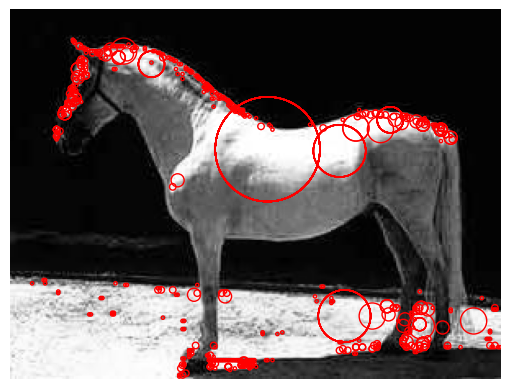

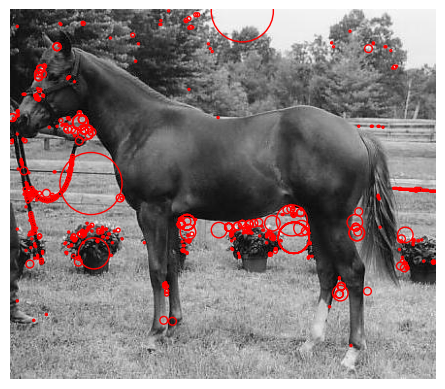

In [27]:
# ------------- MAIN --------------

def blob_detection(sigmas, image_path, num_max, image_name):
    """
    executes blob detection on an image using the Laplacian of Gaussian (LoG) method.

    INPUT:
    sigmas (list): List of sigma values to use for creating LoG filters.
    image_path (str): Path of the image on which to perform blob detection.
    num_max (int): Maximum number of points of interest to be detected for each sigma scale.

    OUTPUT:
    No directly returned value. The function creates a plot of the input image with detected blobs surrounded by circles.
    """

    #image
    im = Image.open(image_path) # open the image
    image = np.array(im)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # array taht contain the points of interest
    max_points = []

    for sigma in sigmas:

        # create the filter and take its dimention
        filter, filter_size = filter_create(sigma)
        # plot(filter_size, filter, "my_filter")

        # do the padding to maintain the coordinates
        image_padding = np.pad(gray_image, int((filter_size-1)/2), mode='edge')

        # convolution of filter on the image
        filter_image = filter_convolution(image_padding, filter, filter_size)

        # take num_max max of the filter image with fixed sigma
        max_points += find_maxima(filter_image, num_max, sigma)


    # points that are very close to each other with respect to sigma are eliminated
    max_points = filter_max_points(max_points.copy())
    #max_points = filter_max_points(max_points)

    #print(filter_max_points)

    # the points of interest are circled and the plot is made
    blob_detection_plot(gray_image, max_points, image_name)



"""
sigmas = [1, 2, 4, 8, 16, 32]
image_path = "horse160.png"
num_max = 100 # number of maximum points that will be taken for every sigma

blob_detection(sigmas, image_path, num_max)

"""
sigmas = [1, 2, 4, 8, 16, 32]
image_path = "blob_detection/image/horse024.png"
image_name = "horse024.png"
num_max = 400

blob_detection(sigmas, image_path, num_max, image_name)

image_path = "blob_detection/image/horse043.png"
image_name = "horse043.png"
blob_detection(sigmas, image_path, num_max, image_name)

# uno buono = 400
# da tenere abbiamo 17 - 21 - 24 - 43

prova